# Testing the first generations method

In [1]:
%load_ext autoreload
%matplotlib notebook
%matplotlib notebook 

import numpy as np
import matplotlib.pyplot as plt
import sys
import logging

import ompy as om
# %matplotlib inline

%autoreload 2

## A) Generated spectrum; idea from AC (see also Larsen2011)

<img src="files/example.png">

[100. 300. 500.]


<IPython.core.display.Javascript object>


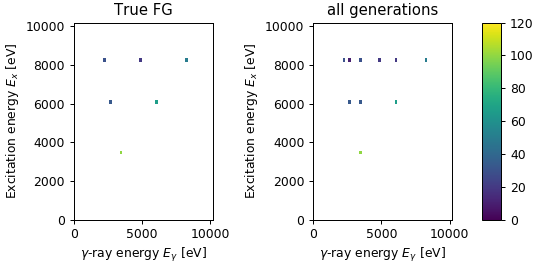

In [2]:
def fill_matrix(mat, Ex, Eg, counts):
    iEx = mat.index_Ex(Ex)    
    iEg = mat.index_Eg(Eg)
#     print(Ex, Eg, iEx, iEg)
    mat[iEx, iEg] = counts
    return mat.Ex[iEx], mat.Eg[iEg]

E = om.E_array_from_calibration(a0=100, a1=200, E_max=10e3)
print(E[:3])
primary_true = np.zeros((E.size, E.size))
primary_true = om.Matrix(primary_true, E.copy(), E.copy())

Ea = primary_true.Ex[primary_true.index_Ex(2e3)]
Ed = primary_true.Ex[primary_true.index_Ex(2.5e3)]
Ef = primary_true.Ex[primary_true.index_Ex(3.5e3)]

E1 = primary_true.Ex[primary_true.index_Ex(Ef)]
E2 = primary_true.Ex[primary_true.index_Ex(E1+Ed)]
E3 = primary_true.Ex[primary_true.index_Ex(E2+Ea)]

fill_matrix(primary_true, E3, E3-E2, 30)
fill_matrix(primary_true, E3, E3-E1, 20)
fill_matrix(primary_true, E3, E3, 50)

fill_matrix(primary_true, E2, E2-E1, 33)
fill_matrix(primary_true, E2, E2, 67)

fill_matrix(primary_true, E1, E1, 100)

firstgen = om.FirstGeneration()
allgen = firstgen.allgen_from_primary(primary_true)

fig, axes = plt.subplots(1,2, constrained_layout= True, figsize=(6,3))
vmin, vmax = 0, 120
primary_true.plot(ax=axes[0], vmin=vmin, vmax=vmax, 
                  title="True FG")
lines, ax, _ = allgen.plot(ax=axes[1], vmin=vmin, vmax=vmax, 
                           title="all generations")
fig.colorbar(lines, ax=ax)

Perform the first generation method

In [3]:
firstgen = om.FirstGeneration()
firstgen.multiplicity_estimation="total"
firstgen.num_iterations=4
primary_total = firstgen(allgen)

firstgen.multiplicity_estimation="statistical"
primary_statistic = firstgen(allgen)
# allgen.plot(vmin=1, vmax=100, scale="log", title="all generations");
# primary.plot(vmin=1, vmax=100, scale="log")

<IPython.core.display.Javascript object>


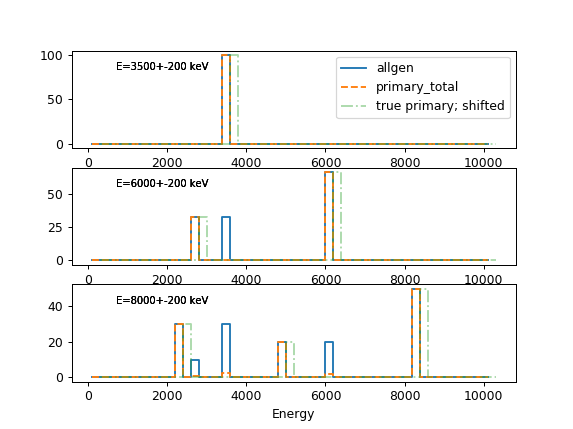

In [4]:
def plot_projections(mat, label, axes, Eproject, **kwargs):
    for i, E in enumerate(Eproject):
        ax = axes[i]
        dE=200
        mat.plot_projection(ax=ax, axis="Eg", Emin=E-dE, Emax=E+dE, label=label, **kwargs)
        ax.text(0.1, .8, f"E={E:.0f}+-{dE:.0f} keV",transform=ax.transAxes, fontsize=8)

Eproject = [3500, 6000, 8000] 
fig, axes = plt.subplots(3,1)

plot_projections(allgen, "allgen", axes, Eproject)
plot_projections(primary_total, "primary_total", axes, Eproject, linestyle="--")

primary_true_plot = primary_true.copy()
primary_true_plot.Eg += (primary_true_plot.Eg[1] + primary_true_plot.Eg[0])/2
plot_projections(primary_true_plot, "true primary; shifted", axes, Eproject, 
                 linestyle="-.", alpha=0.4)
axes[0].legend()
plt.show()

<IPython.core.display.Javascript object>


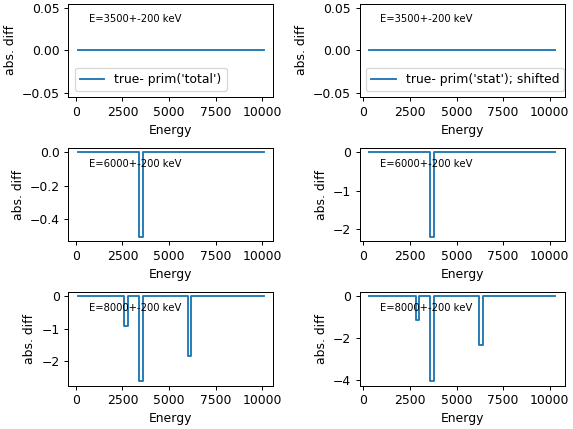

In [5]:
fig, axes = plt.subplots(3,2, constrained_layout=True)
diff_total = primary_true - primary_total
diff_statistical = primary_true - primary_statistic

# for the jitter plotting!
diff_statistical.Eg += (diff_statistical.Eg[1] + diff_statistical.Eg[0])/2

plot_projections(diff_total, "true- prim('total')", axes[:,0], Eproject)
plot_projections(diff_statistical, "true- prim('stat'); shifted", axes[:,1], Eproject)

axes[0,0].legend(loc=3)
axes[0,1].legend(loc=3)

for ax in axes.flatten():
    ax.set_ylabel("abs. diff")
plt.show()

This is after just `firstgen.num_iterations = 4` iterations. After some more iterations, the spectra with the `firstgen.multiplicity_estimation="total"` will be identical to the true spectrum. 

In [6]:
firstgen.num_iterations=10
firstgen.multiplicity_estimation="total"
primary_total = firstgen(allgen)

firstgen.multiplicity_estimation="statistical"
primary_statistic = firstgen(allgen)

<IPython.core.display.Javascript object>


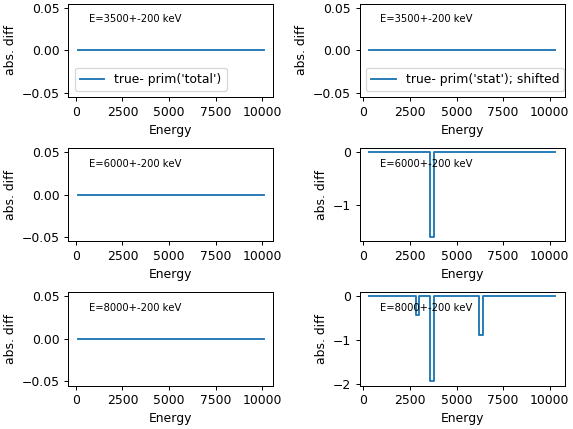

In [7]:
fig, axes = plt.subplots(3,2, constrained_layout=True)
diff_total = primary_true - primary_total
diff_statistical = primary_true - primary_statistic

# for the jitter plotting!
diff_statistical.Eg += (diff_statistical.Eg[1] + diff_statistical.Eg[0])/2

plot_projections(diff_total, "true- prim('total')", axes[:,0], Eproject)
plot_projections(diff_statistical, "true- prim('stat'); shifted", axes[:,1], Eproject)

axes[0,0].legend(loc=3)
axes[0,1].legend(loc=3)

for ax in axes.flatten():
    ax.set_ylabel("abs. diff")
plt.show()

## B) Other simple mock spectra

In [8]:
# logger = om.introspection.get_logger('firstgeneration', 'DEBUG')
def normalize_rows(array: np.ndarray) -> np.ndarray:
    """ Normalize each row to unity """
    return om.div0(array, array.sum(axis=1).reshape(array.shape[1], 1))

def generate_simple_allgen(E, xs=None):
    values = np.ones((E.size, E.size))
    values = np.tril(values)
    values = normalize_rows(values)
    primaries = om.Matrix(values=values, Eg=E, Ex=E)
    allgen = firstgen.allgen_from_primary(primaries, xs)
    return allgen, primaries

**Note that the results depend on the energy grid we send in due to some default values for the multiplicity estimation**

<IPython.core.display.Javascript object>


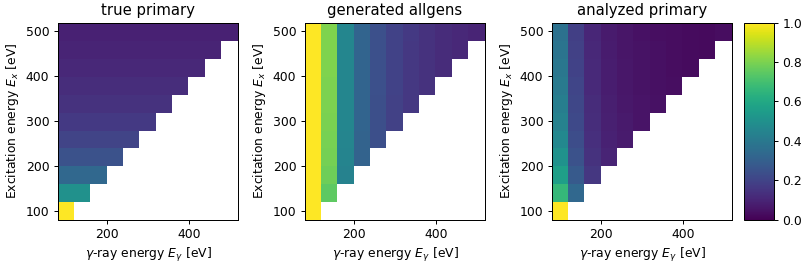

<IPython.core.display.Javascript object>


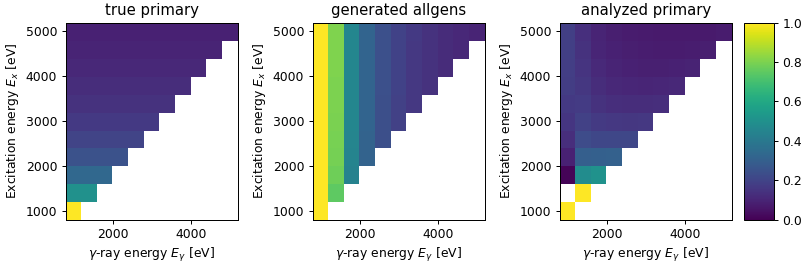

<IPython.core.display.Javascript object>


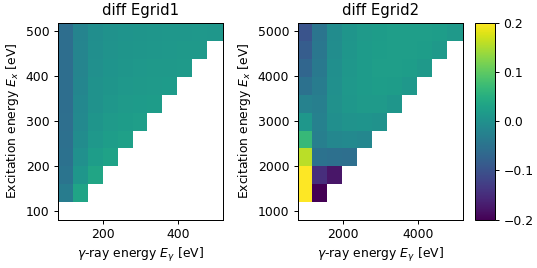

In [9]:
#plot settings
vmin = 0
vmax = 1

# first fg / first E grid
E = np.linspace(1,5,11)*1e2
allgen, primaries = generate_simple_allgen(E)
primary_analyzed = firstgen(allgen)
primary_analyzed.values = normalize_rows(primary_analyzed.values)

fig, axes = plt.subplots(1,3, figsize=(9,3), constrained_layout=True)
primaries.plot(ax=axes[0], title="true primary", vmin=vmin, vmax=vmax)
allgen.plot(ax=axes[1], title="generated allgens", vmin=vmin, vmax=vmax)
lines, ax, _ = primary_analyzed.plot(ax=axes[2], title="analyzed primary", vmin=vmin, vmax=vmax)
fig.colorbar(lines, ax=ax)

diff1 = primaries-primary_analyzed

# second fg / second E grid
E = np.linspace(1,5,11)*1e3
allgen, primaries = generate_simple_allgen(E)
primary_analyzed = firstgen(allgen)
primary_analyzed.values = normalize_rows(primary_analyzed.values)

fig, axes = plt.subplots(1,3, figsize=(9,3), constrained_layout=True)
primaries.plot(ax=axes[0], title="true primary", vmin=vmin, vmax=vmax)
allgen.plot(ax=axes[1], title="generated allgens", vmin=vmin, vmax=vmax)
lines, ax, _= primary_analyzed.plot(ax=axes[2], title="analyzed primary", vmin=vmin, vmax=vmax)
fig.colorbar(lines, ax=ax)

diff2 = primaries-primary_analyzed

# plot the differences
fig, axes = plt.subplots(1, 2, figsize=(6,3), constrained_layout=True)
diff1.plot(ax=axes[0], title="diff Egrid1", scale="linear", vmin=-1, vmax=1)
lines, ax, _ = diff2.plot(ax=axes[1], title="diff Egrid2", scale="linear", vmin=-0.2, vmax=0.2)
fig.colorbar(lines, ax=ax)

## Adding a cross-section dependence: Does not change the results

<IPython.core.display.Javascript object>


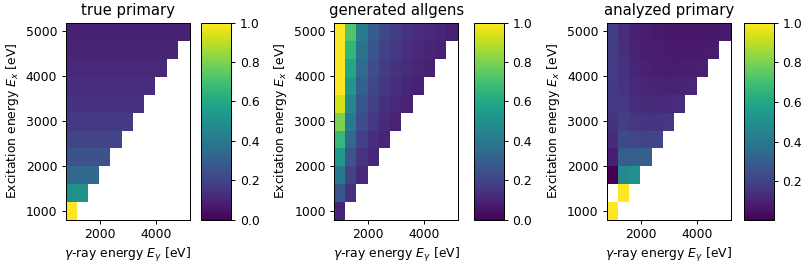

<IPython.core.display.Javascript object>


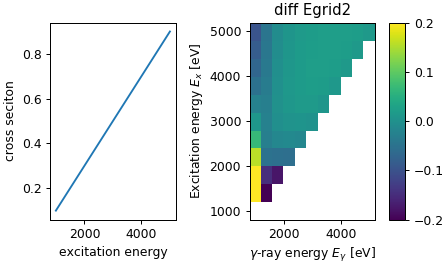

In [10]:
firstgen = om.FirstGeneration()
E = np.linspace(1,5,11)*1e3
xs = np.linspace(0.1,0.9,11)
allgen, primaries = generate_simple_allgen(E, xs)
primary_analyzed = firstgen(allgen)
primary_analyzed.values = normalize_rows(primary_analyzed.values)



fig, axes = plt.subplots(1,3, figsize=(9,3), constrained_layout=True)
lines, ax, _= primaries.plot(ax=axes[0], title="true primary", vmin=vmin, vmax=vmax)
fig.colorbar(lines, ax=ax)
lines, ax, _= allgen.plot(ax=axes[1], title="generated allgens", vmin=vmin, vmax=vmax)
fig.colorbar(lines, ax=ax)
lines, ax, _= primary_analyzed.plot(ax=axes[2], title="analyzed primary")
fig.colorbar(lines, ax=ax)

diff2 = primaries-primary_analyzed


# plot the differences
fig, axes = plt.subplots(1, 2, figsize=(5,3), constrained_layout=True)
axes[0].plot(E, xs)
axes[0].set_xlabel("excitation energy")
axes[0].set_ylabel("cross seciton")

lines, ax, _ = diff2.plot(ax=axes[1], title="diff Egrid2", scale="linear", vmin=-0.2, vmax=0.2)
fig.colorbar(lines, ax=ax)

For a "reasonable energy grid" -- somethings that resembles our data, this again isn't perfect, but it is probably all right. Can we quantify this better? Should the be used in a unit test?